In [2]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [3]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [4]:
NUM_CLASSES = 3

# Dataset reading

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,103
Trainable params: 1,103
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
18/24 [=====================>........] - ETA: 0s - loss: 1.1601 - accuracy: 0.3694
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
24/24 [==============================] - 5s 49ms/step - loss: 1.1414 - accuracy: 0.3803 - val_loss: 1.0364 - val_accuracy: 0.5483
Epoch 2/1000
18/24 [=====================>........] - ETA: 0s - loss: 1.0562 - accuracy: 0.4301
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
24/24 [==============================] - 0s 15ms/step - loss: 1.0448 - accuracy: 0.4428 - val_loss: 0.9637 - val_accuracy: 0.6174
Epoch 3/1000
21/24 [=========================>....] - ETA: 0s - loss: 1.0016 - accuracy: 0.4676
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
24/24 [==============================] - 0s 15ms/step - loss: 1.0005 - accuracy: 0.4674 - val_loss: 0.9073 - val_accuracy: 0.6982
Epoch 4/1000
17/24 [====================>.........] - ETA: 0s - loss: 0.9573 - accuracy: 0.525

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 5ms/step - loss: 0.1612 - accuracy: 0.9714


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 250ms/step
[0.9297225  0.0665868  0.00369072]
0


# Confusion matrix

32/32 [==============================] - 0s 5ms/step


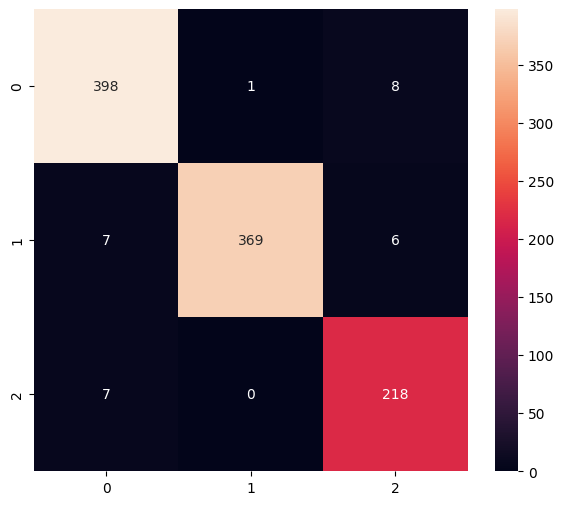

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       407
           1       1.00      0.97      0.98       382
           2       0.94      0.97      0.95       225

    accuracy                           0.97      1014
   macro avg       0.97      0.97      0.97      1014
weighted avg       0.97      0.97      0.97      1014



In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [19]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [20]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\aniku\AppData\Local\Temp\tmpsqcpwqh7\assets


INFO:tensorflow:Assets written to: C:\Users\aniku\AppData\Local\Temp\tmpsqcpwqh7\assets


6500

# Inference test

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [22]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [24]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [25]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.9297225  0.06658679 0.00369072]
0
